In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats

In [2]:
cd CSVs

/Users/ritusinghal/Desktop/Metis/mta-project-1/CSVs


#### Load Data

In [3]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])
data


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,00:00:00,REGULAR,7053483,2390505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,04:00:00,REGULAR,7053511,2390508
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,08:00:00,REGULAR,7053534,2390536
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,12:00:00,REGULAR,7053618,2390596
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,16:00:00,REGULAR,7053841,2390655
...,...,...,...,...,...,...,...,...,...,...,...
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,05:00:00,REGULAR,5554,376
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,09:00:00,REGULAR,5554,376
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,13:00:00,REGULAR,5554,376
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,17:00:00,REGULAR,5554,376


### Clean Data

remove spaces from column names

In [7]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [8]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [9]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()


#### Find total traffic

Add shifted columns to show previous entries and exits

In [10]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
#grouped_time.head()

In [11]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True) 

Remove counter errors from total entries/exits that occur from counters resetting

In [12]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter_ex = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter_ent = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [13]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=100000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=100000)
#grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts, axis=1, max_counter=1000000)

In [14]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_ENTRIES"])) < 3)] #filtering
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_EXITS"])) < 3)] #filtering
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [15]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering

drop uneeded columns

In [16]:
grouped_time.columns = grouped_time.columns.str.replace(' ', '')
grouped_time.drop(['C/A','UNIT','SCP','LINENAME', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS','TOTAL_ENTRIES','TOTAL_EXITS',], axis=1, inplace = True)
#grouped_time.head(100)
#grouped_time.shape

In [68]:
grouped_time.head(100)

,STATION,DIVISION,DATE,TIME,DESC,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC
1,59 ST,BMT,2019-05-11,04:00:00,REGULAR,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,31.0
2,59 ST,BMT,2019-05-11,08:00:00,REGULAR,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,51.0
3,59 ST,BMT,2019-05-11,12:00:00,REGULAR,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,144.0
4,59 ST,BMT,2019-05-11,16:00:00,REGULAR,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,282.0
5,59 ST,BMT,2019-05-11,20:00:00,REGULAR,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,339.0
...,...,...,...,...,...,...,...,...,...
98,59 ST,BMT,2019-05-13,00:00:00,REGULAR,2019-05-13 00:00:00,A002R05102-03-0059 ST,Monday,144.0
99,59 ST,BMT,2019-05-13,04:00:00,REGULAR,2019-05-13 04:00:00,A002R05102-03-0059 ST,Monday,9.0
100,59 ST,BMT,2019-05-13,08:00:00,REGULAR,2019-05-13 08:00:00,A002R05102-03-0059 ST,Monday,281.0
101,59 ST,BMT,2019-05-13,08:30:55,REGULAR,2019-05-13 08:30:55,A002R05102-03-0059 ST,Monday,119.0


In [69]:
grouped_day = data.groupby(['DATE','Turnstile','STATION'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = data.groupby(['STATION','DATE']).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = grouped.set_index('STATION')
#grouped.head()

In [70]:
#grouped_day.head()

In [71]:
#grouped.columns = [ 'Station', 'Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
grouped_day.columns = [ 'Date', 'Turnstile', 'Station','ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.columns = ['ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.dtypes

In [72]:
grouped_day.head()

,Date,Turnstile,Station,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX
0,2019-03-30,A002R05102-00-0059 ST,59 ST,6999064,6999796,2373568,2373837
1,2019-03-30,A002R05102-00-0159 ST,59 ST,6238770,6239372,1399138,1399289
2,2019-03-30,A002R05102-03-0059 ST,59 ST,1211476,1211761,4553166,4554337
3,2019-03-30,A002R05102-03-0159 ST,59 ST,1049198,1049913,1621305,1622549
4,2019-03-30,A002R05102-03-0259 ST,59 ST,6132784,6133502,8279411,8280248


Find total entries exits, and traffic

In [73]:
grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Entries']
#grouped_day.head()

In [74]:
grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1,inplace = True)



Removing Outlier data from Total_traffic column (Removing anything outside 3 sigma)

In [75]:
grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

In [76]:
#grouped_time[grouped_time["ENTRIES"] < grouped_time["PREV_ENTRIES"]].head()

In [77]:
#grouped_time = data.sort_values(['Date_Time']).groupby(['Turnstile','STATION','DIVISION','Date_Time'],as_index = False).agg({'ENTRIES': ['diff'], 'EXITS': ['diff']})

In [78]:
#grouped_time = data
#grouped_time.sort_values(['Turnstile','Date_Time'],inplace = True)
#grouped_time.head(5)
#entry_vals = grouped_time['ENTRIES'].values
#exit_vals = grouped_time['EXITS'].values
#len(entry)
#len (entry_vals[:-1])
#len (entry_vals[1:])
#diffs_entry = entry_vals[1:] - entry_vals[:-1]
#diffs_exit = exit_vals[1:] - exit_vals[:-1]
#diffs_entry = np.append(diffs_entry,0)
#diffs_exit = np.append(diffs_exit,0)
#grouped_time['diffs_entry'] = grouped_time.groupby(['Turnstile'])['ENTRIES'].diff()
#grouped_time['diffs_exit'] = grouped_time.groupby(['Turnstile'])['EXITS'].diff()
#mask = !((grouped_time['diffs_entry'] == 0) && (grouped_time['diffs_exit'] == 0))
#mask =   grouped_time['diffs_entry'] == 0
#grouped_time = grouped_time[grouped_time['diffs_entry'] ]
#grouped_time['diffs_entry'] = grouped_time.rolling_apply(data['ENTRIES'], 2, lambda x: x[1] - x[0])
#grouped_time['diffs_exit'] = grouped_time.rolling_apply(data['EXITS'], 2, lambda x: x[1] - x[0])
#grouped_time.head()
#mask
#grouped_time.head()

In [79]:
#entry_vals = grouped_time['ENTRIES'].values
#entry_vals[1:]

In [80]:

grouped_day['Date'] = pd.to_datetime(grouped_day['Date'], cache=True)
grouped_day['Week_Day'] = grouped_day['Date'].dt.day_name()

In [81]:
grouped_day.head()

,Date,Turnstile,Station,Total_Traffic,Week_Day
0,2019-03-30,A002R05102-00-0059 ST,59 ST,1001,Saturday
1,2019-03-30,A002R05102-00-0159 ST,59 ST,753,Saturday
2,2019-03-30,A002R05102-03-0059 ST,59 ST,1456,Saturday
3,2019-03-30,A002R05102-03-0159 ST,59 ST,1959,Saturday
4,2019-03-30,A002R05102-03-0259 ST,59 ST,1555,Saturday


#### Combine data

### Finding top 10 visited stations

In [82]:
Total_ridership = grouped_day.groupby(['Station']).Total_Traffic.sum().reset_index()

In [52]:
Total_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)


In [17]:
Total_ridership = grouped_time.groupby(['STATION']).TOTAL_TRAFFIC.sum().reset_index()
Total_ridership.sort_values(by=['TOTAL_TRAFFIC'],inplace = True, ascending = False)

In [68]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.TOTAL_TRAFFIC//1000
    station_list = rows.STATION
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(20)


,STATION,TOTAL_TRAFFIC
61,34 ST-PENN STA,20435879.0
232,GRD CNTRL-42 ST,15374876.0
59,34 ST-HERALD SQ,13653317.0
46,23 ST,12962556.0
352,TIMES SQ-42 ST,12751254.0
14,14 ST-UNION SQ,12535312.0
225,FULTON ST,11697505.0
68,42 ST-PORT AUTH,11668502.0
110,86 ST,10749092.0
9,125 ST,9755552.0


In [59]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.Total_Traffic 
    station_list = rows.Station
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(20)


AttributeError: 'Series' object has no attribute 'Total_Traffic'

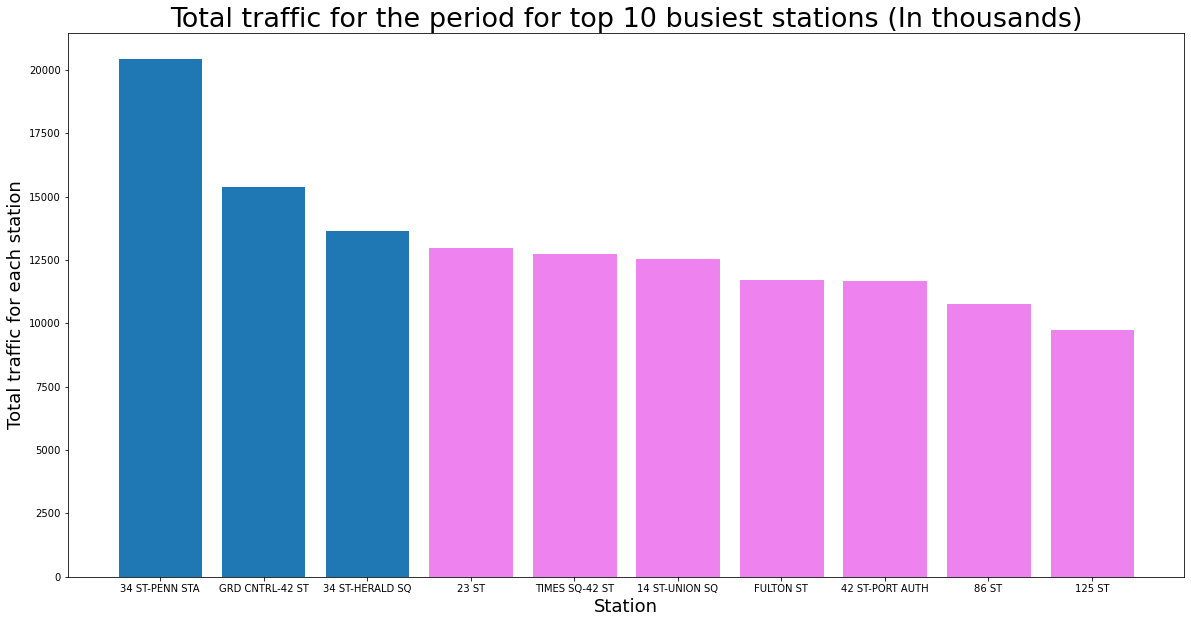

In [70]:
#plt.ylim(9000000,22000000)
top_inc_bar = plt.bar(indices, Row_list)
plt.xlabel("Station", fontsize=18)
plt.ylabel("Total traffic for each station",fontsize=18)
plt.title("Total traffic for the period for top 10 busiest stations (In thousands)",fontsize=27)
plt.rcParams.update({'font.size': 10})
top_inc_bar[3].set_color('violet')
top_inc_bar[4].set_color('violet')
top_inc_bar[5].set_color('violet')
top_inc_bar[6].set_color('violet')
top_inc_bar[7].set_color('violet')
top_inc_bar[8].set_color('violet')
top_inc_bar[9].set_color('violet')
#top_inc_bar[4].set_color('violet')
plt.savefig('Top10_traffic_stations.png', dpi=300)


Top 10 Busy Stations, We will focus on top5 of these.

In [41]:
indices

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 'PATH NEW WTC',
 '14 ST-UNION SQ',
 '23 ST',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH',
 'FULTON ST',
 '86 ST']

### Find high traffic days

In [20]:
Total_Weekly_ridership = grouped_time.groupby(['Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
#Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.mean().reset_index()
Total_Weekly_ridership.sort_values(by=['TOTAL_TRAFFIC'],inplace = True, ascending = False)
Total_Weekly_ridership.head()

,Week_Day,TOTAL_TRAFFIC
6,Wednesday,116702638.0
4,Thursday,116094534.0
5,Tuesday,113661501.0
0,Friday,112009149.0
1,Monday,103251369.0


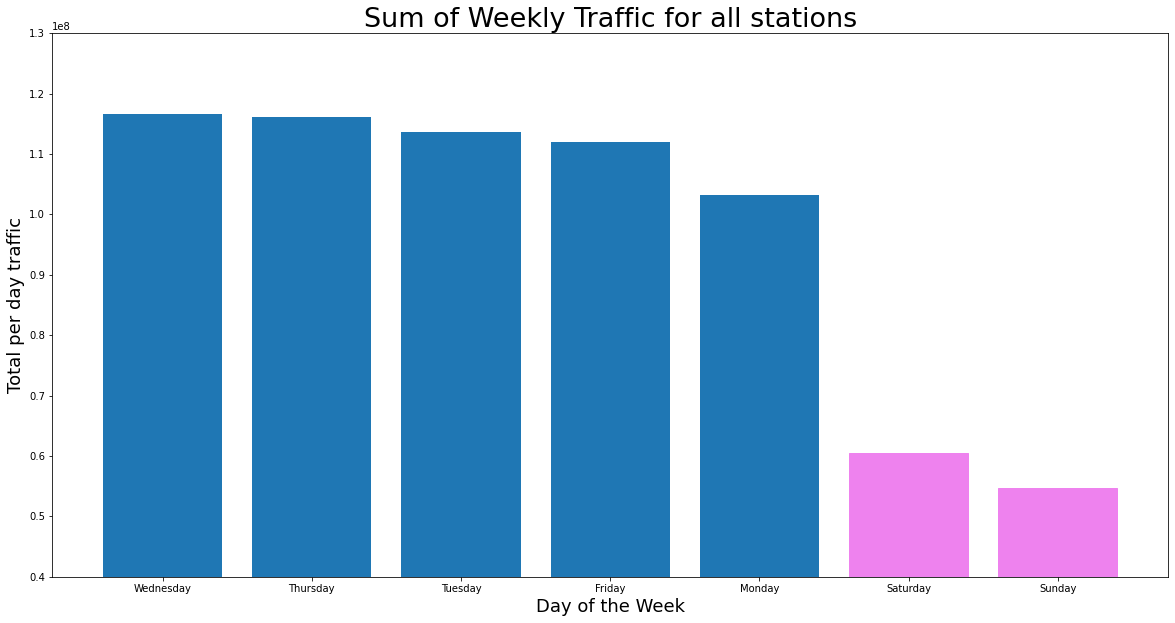

In [63]:
#plt.ylim(1610000000000,1620000000000)
plt.ylim(40000000,130000000)
top_inc_bar = plt.bar(Total_Weekly_ridership['Week_Day'], Total_Weekly_ridership['TOTAL_TRAFFIC'])
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Total per day traffic",fontsize=18)
plt.title("Sum of Weekly Traffic for all stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
top_inc_bar[5].set_color('violet')
top_inc_bar[6].set_color('violet')
plt.savefig('total_weekly_traffic.png', dpi=300)

Based on this it seems like weekends see much less traffic compared to weekdays. So WWTF should focus more on weekdays 

In [22]:
Top5 = Total_ridership['STATION'][0:5].tolist()
Top5_stations = grouped_time[grouped_time['STATION'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['STATION','Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['STATION','DATE']).TOTAL_TRAFFIC.sum().reset_index()
#Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.mean().reset_index()

#### Weekly Plot for Top5 stations

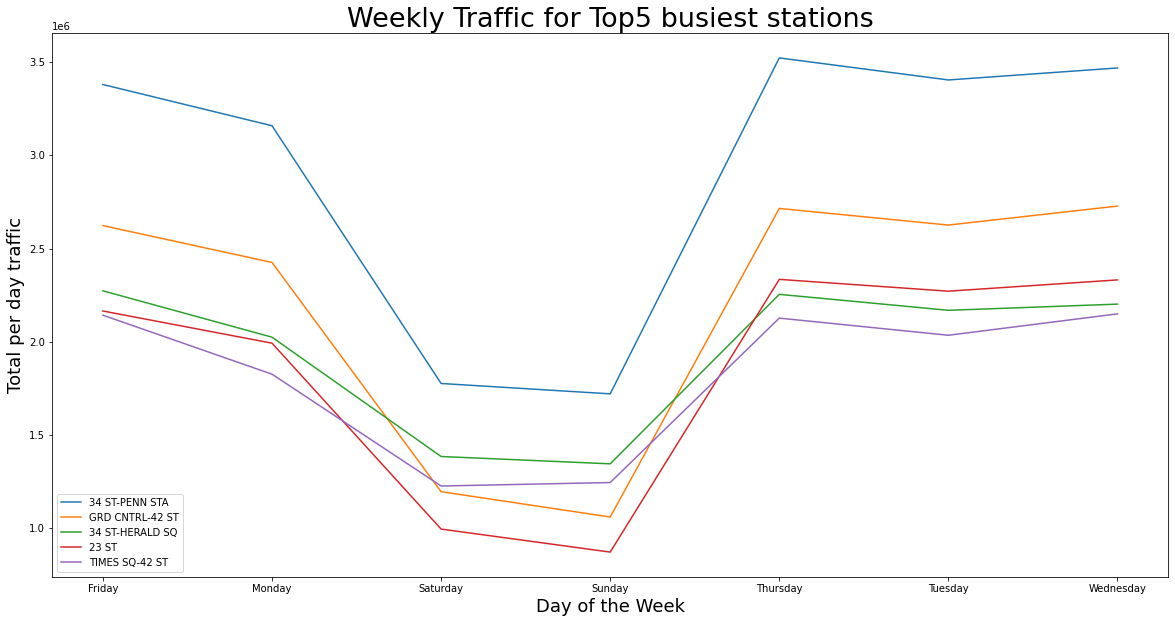

In [60]:

for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['STATION'] == stations]
#    print(station)
    plt.plot(station['Week_Day'],station['TOTAL_TRAFFIC'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Total per day traffic",fontsize=18)
plt.title("Weekly Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_weekly_traffic.png', dpi=300)
plt.legend()
plt.show()



Looking at the plot seems like top5 stations are also showing a dip on weekends, but PATH NEW WTC station is oblitrating seeing the trend properly. This needs to be investigated further. Also, to see the trend for rest of the station we will do another plot removing the data for PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
        plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This is also showing the dip in weekend more clearly. But GRD CNTRL-42 ST shows peak on thursday - which needs to be investigated.

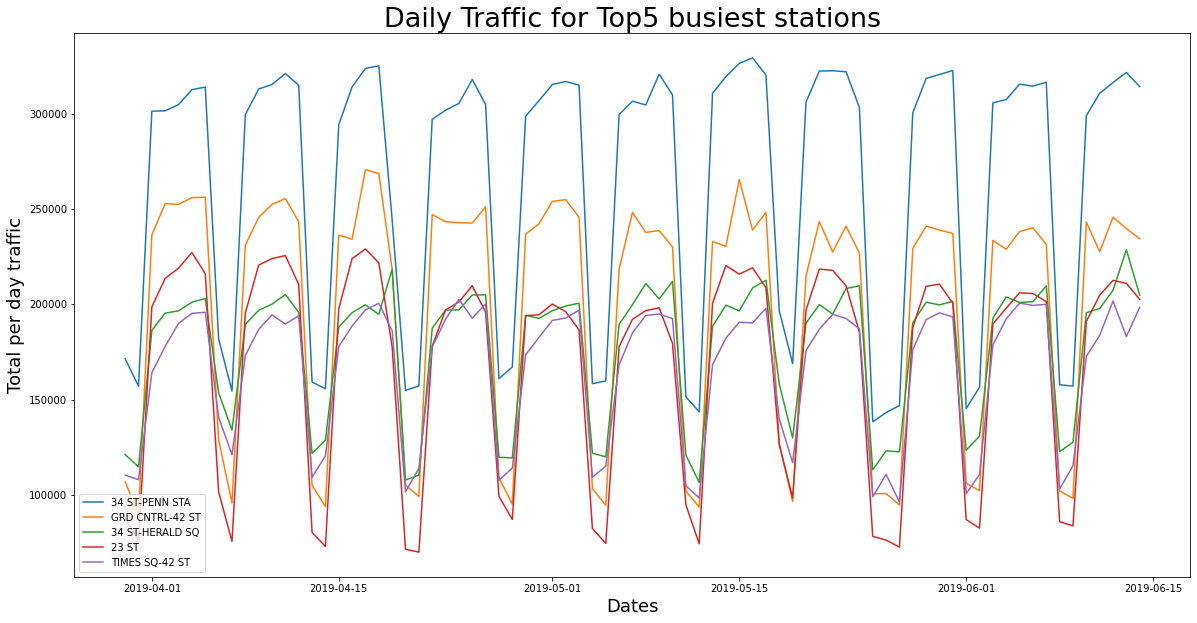

In [59]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['STATION'] == stations]
#    print(station)
    plt.plot(station['DATE'],station['TOTAL_TRAFFIC'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Total per day traffic",fontsize=18)
plt.title("Daily Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_daily_traffic.png', dpi=300)
plt.legend()
plt.show()
#plt.legend()
#plt.show()

This plot is also showing some abnormal values for some of the days for PATH NEW WTC. Two of these dates are looking on thursdays. We will look at rest of the stations removing PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
        plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot also seems to have some outliers. But In general trend is clear Traffic takes a dip on weekends and remains kind of static on weekdays

### Find peak hours

In [25]:
Top10 = Total_ridership['STATION'][0:10].tolist()
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_stations.head()
#Top10
Top10_station_hourly = Top10_stations.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
Top10_station_hourly.head()
#Top5_station_Daily = Top5_stations.groupby(['Station','Date']).Total_Traffic.sum().reset_index()

,STATION,TIME,TOTAL_TRAFFIC
0,125 ST,00:00:00,551016.0
1,125 ST,01:00:00,407250.0
2,125 ST,04:00:00,129323.0
3,125 ST,05:00:00,102593.0
4,125 ST,05:00:01,622.0


In [57]:
Top10_station_hourly.dtypes

STATION           object
TIME              object
TOTAL_TRAFFIC    float64
dtype: object

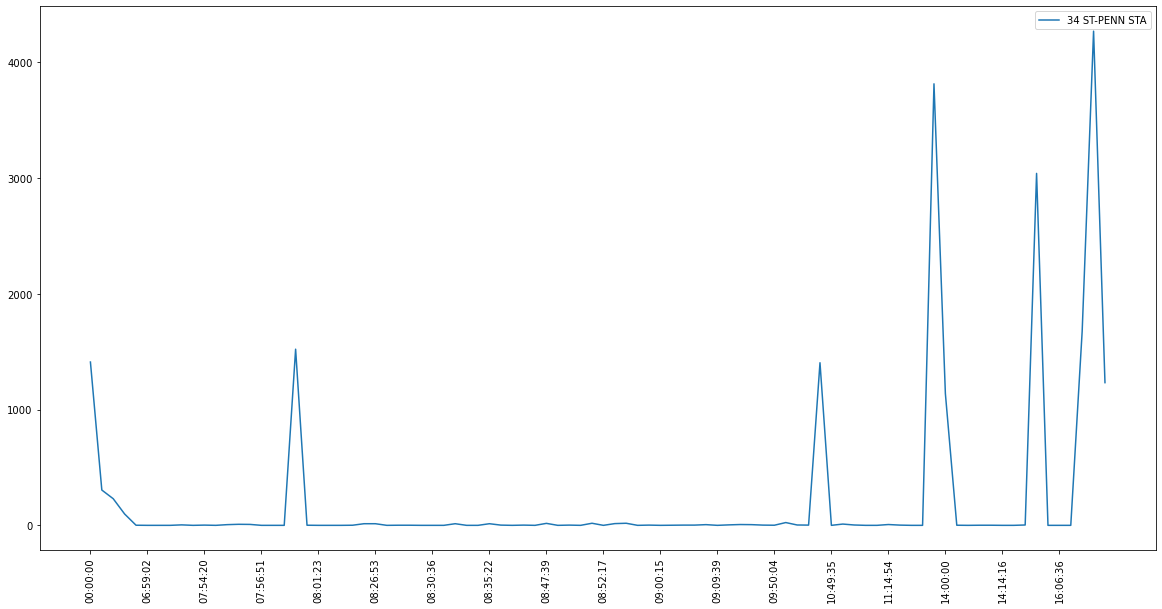

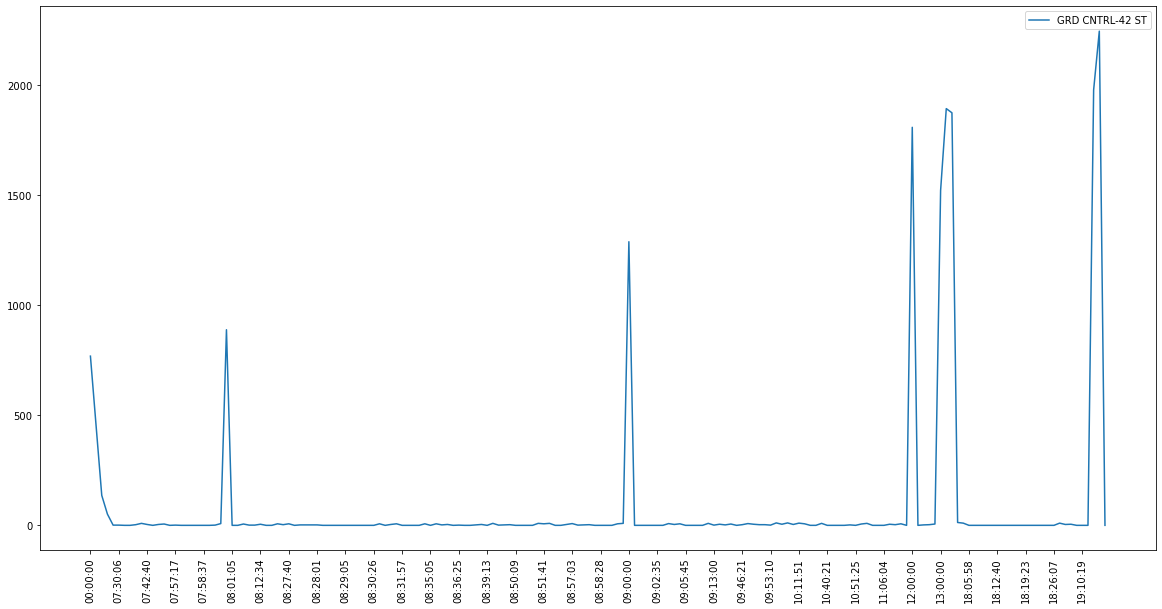

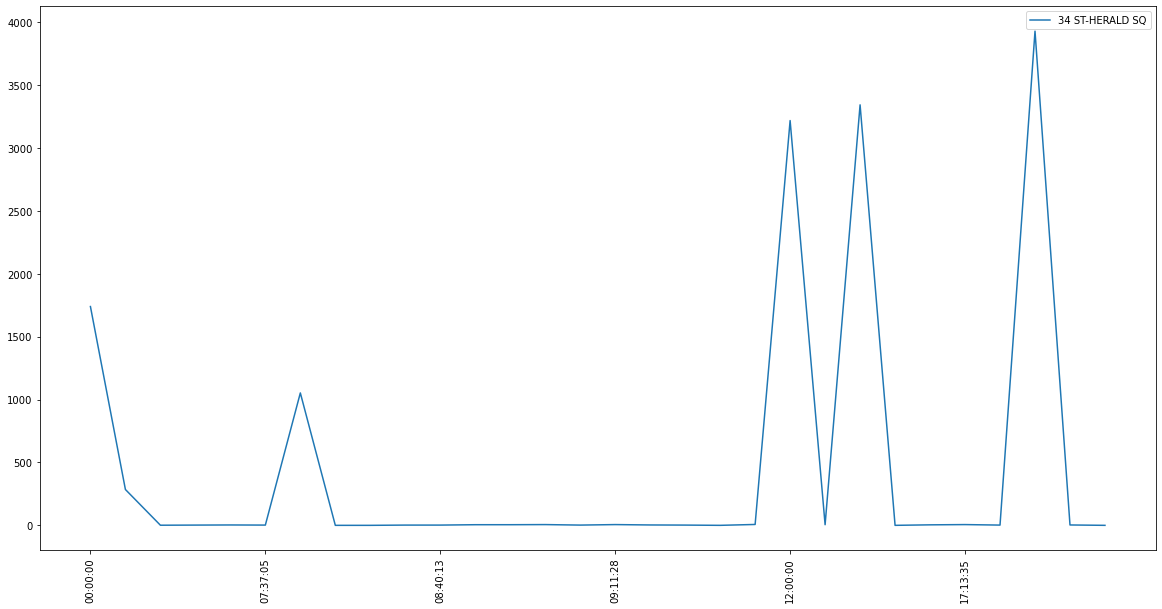

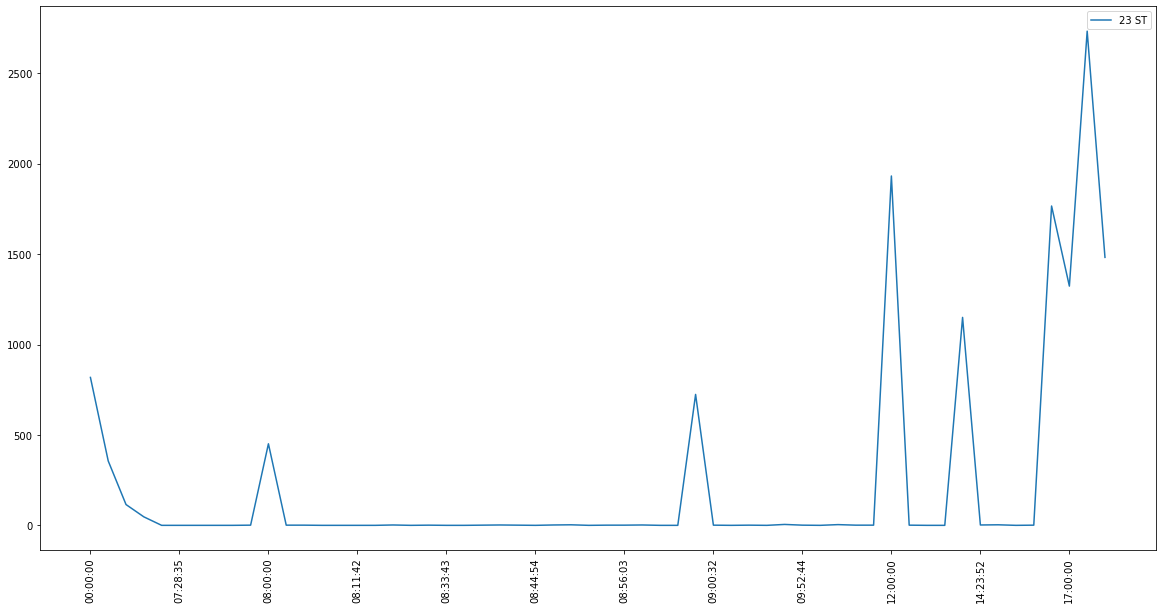

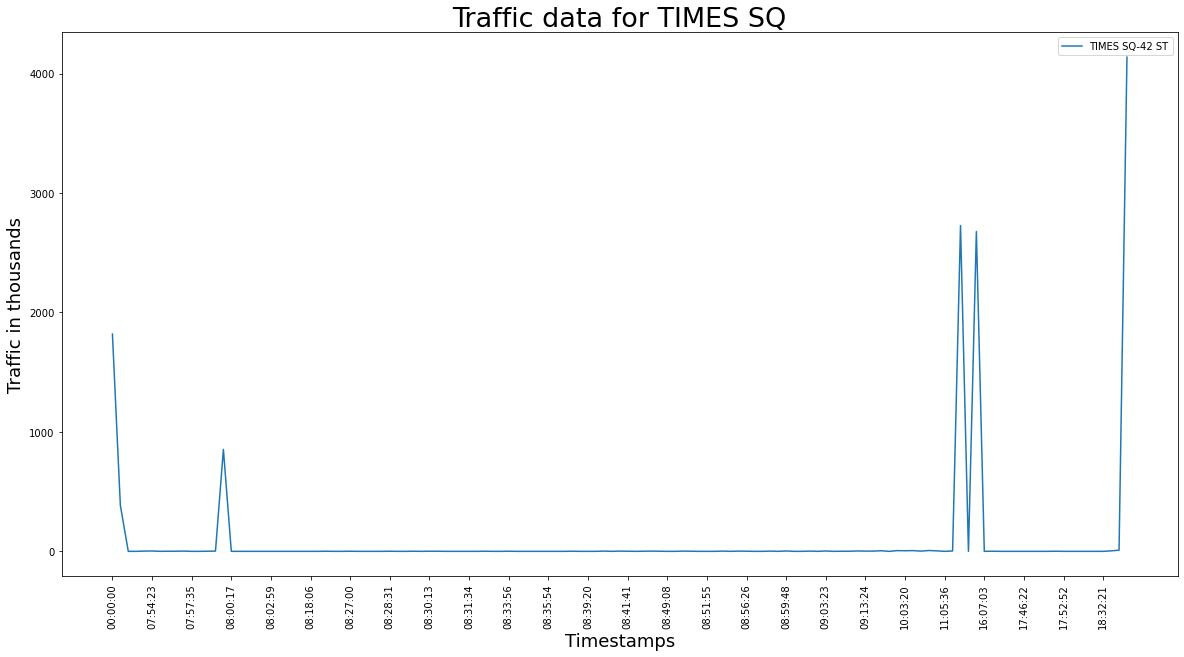

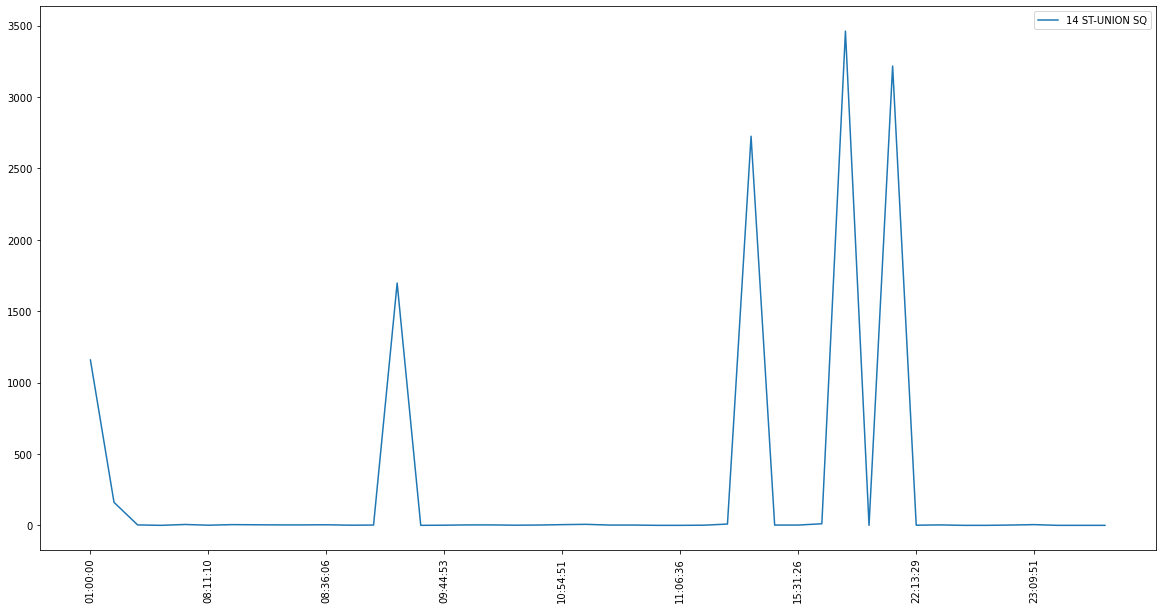

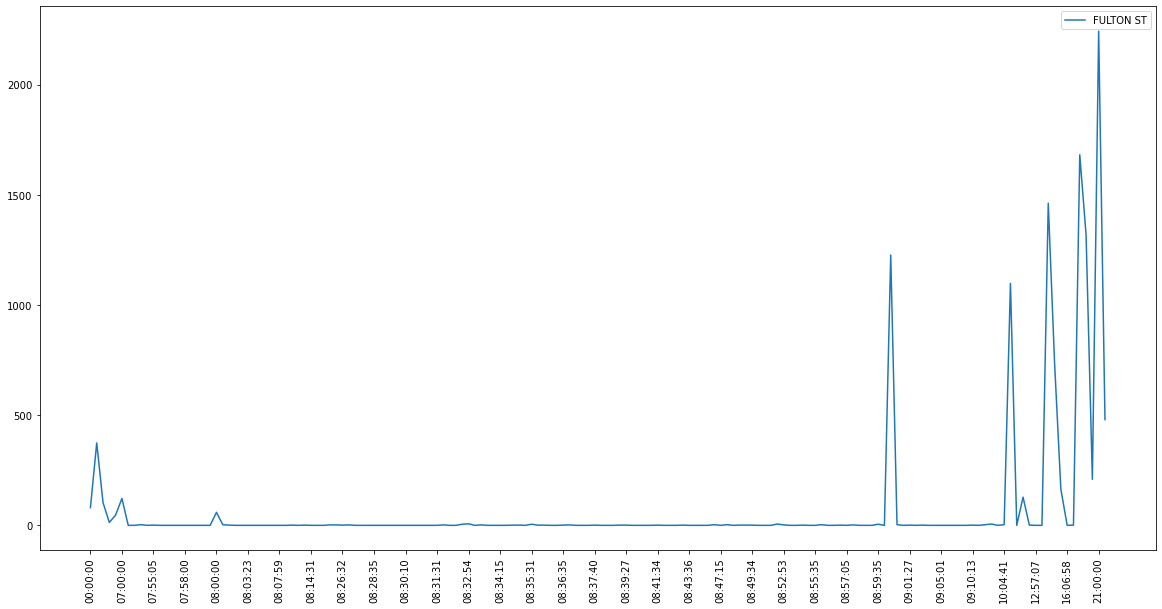

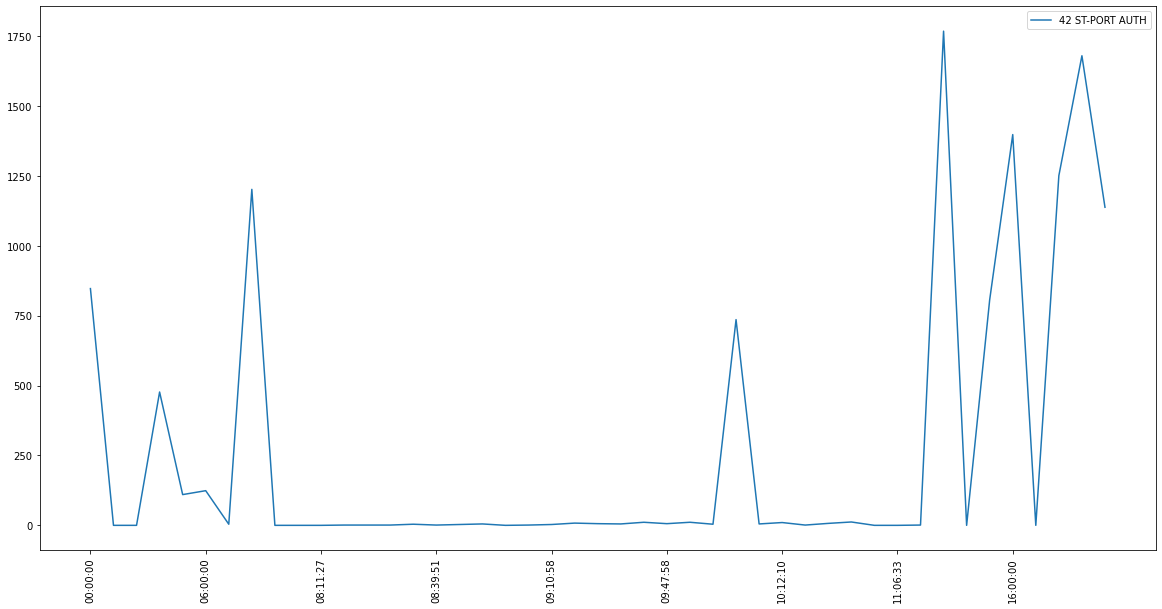

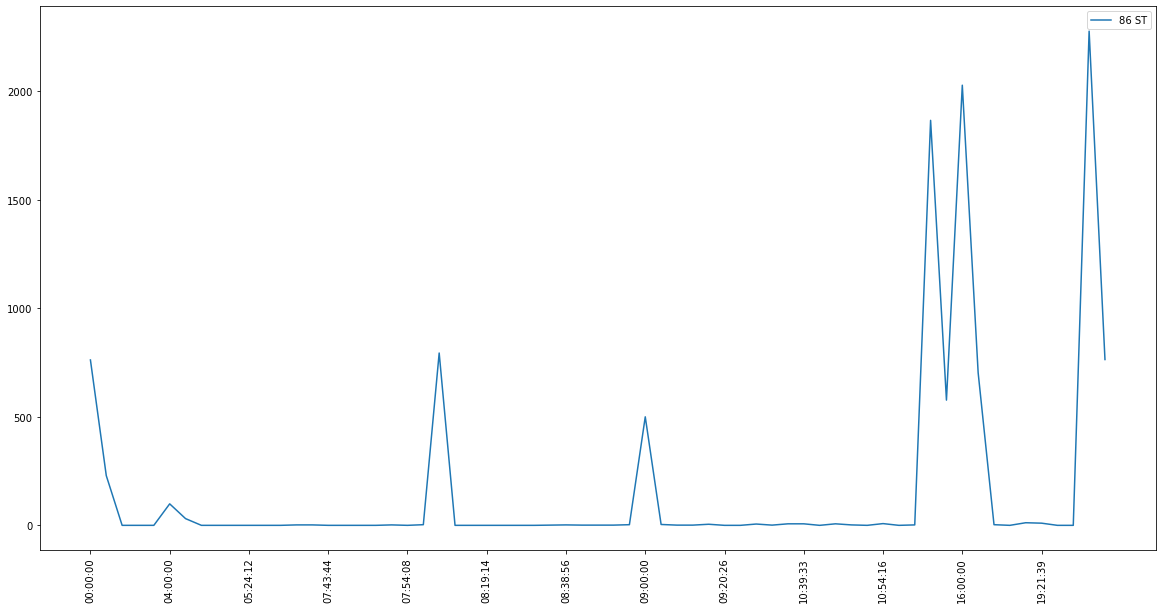

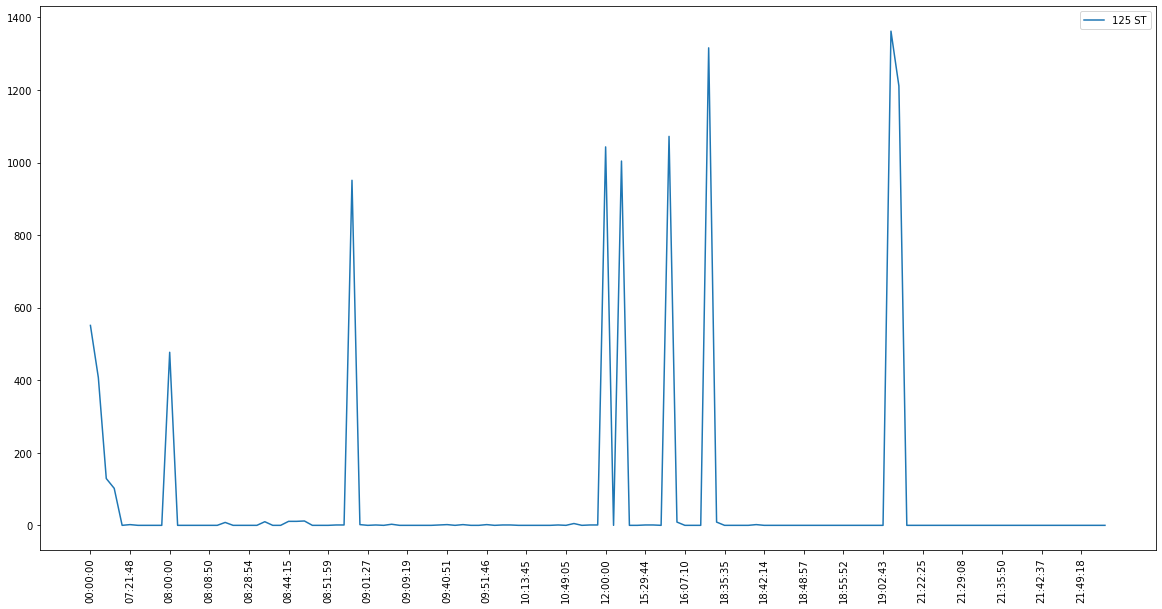

In [79]:
#Top10_station_hourly['TIME'].dtype
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
for stations in Top10:
     station = Top10_station_hourly[Top10_station_hourly['STATION'] == stations]
#    print(station)
     fig, ax = plt.subplots()
     ax.plot(station['TIME'],station['TOTAL_TRAFFIC']//1000,label = stations)
     ax.set_xticks(ax.get_xticks()[::5])
     plt.xticks(rotation = 'vertical')
     plt.legend()
     if stations == "TIMES SQ-42 ST":
            plt.xlabel("Timestamps",fontsize = 18)
            plt.ylabel("Traffic in thousands",fontsize = 18)
            plt.title("Traffic data for TIMES SQ", fontsize = 27)
            plt.rcParams.update({'font.size': 10})
            plt.savefig('Times_traffic.png', dpi=300)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
#ax.set_xticks(ax.get_xticks()[::10])
#plt.legend()
plt.show()



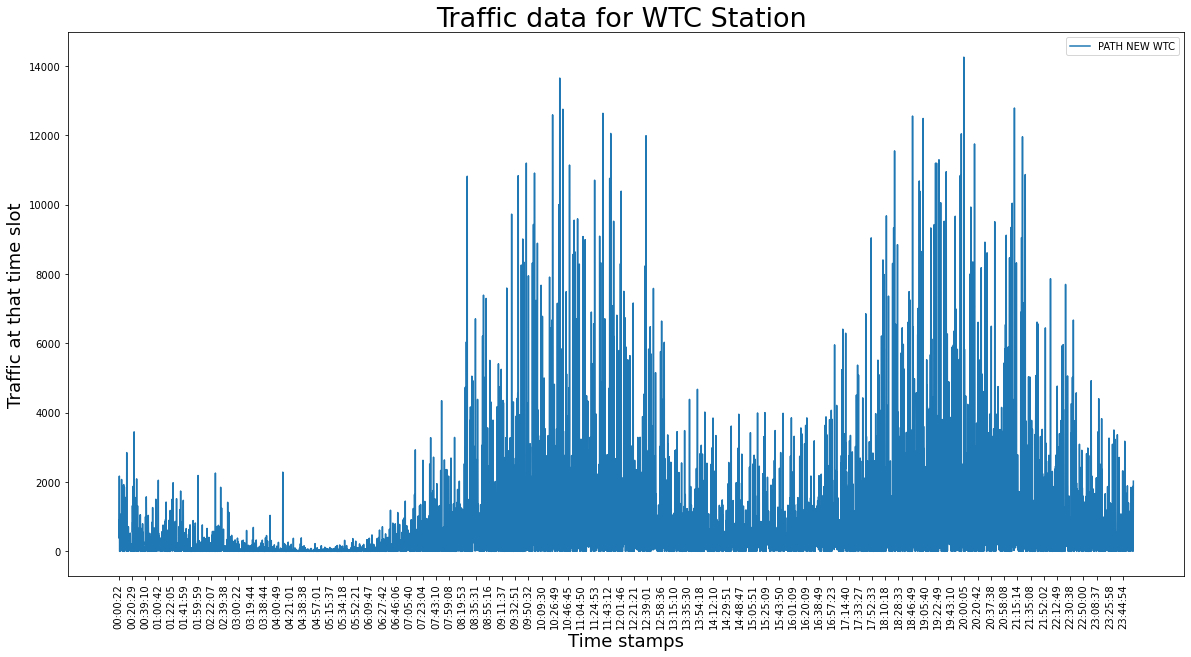

In [71]:
wtc_station = grouped_time[grouped_time['STATION'] == "PATH NEW WTC"]
wtc_station_hourly = wtc_station.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
fig, ax = plt.subplots()
ax.plot(wtc_station_hourly['TIME'],wtc_station_hourly['TOTAL_TRAFFIC'],label = "PATH NEW WTC")
ax.set_xticks(ax.get_xticks()[::100])
plt.xticks(rotation = 'vertical')
plt.xlabel("Time stamps", fontsize=18)
plt.ylabel("Traffic at that time slot",fontsize=18)
plt.title("Traffic data for WTC Station ",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('WTC_traffic.png', dpi=300)
plt.legend()
plt.show()


### Find high traffic areas for games

### Find top stations in each area code

In [ ]:
loc_data = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
print(loc_data.Borough.unique())
loc_data.tail()

In [31]:
grouped_time['FIRST'] =  grouped_time.TIME.astype(str).str[:2].astype(int)
grouped_time.head(20)

,STATION,DIVISION,DATE,TIME,DESC,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,FIRST
1,59 ST,BMT,2019-05-11,04:00:00,REGULAR,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,31.0,4
2,59 ST,BMT,2019-05-11,08:00:00,REGULAR,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,51.0,8
3,59 ST,BMT,2019-05-11,12:00:00,REGULAR,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,144.0,12
4,59 ST,BMT,2019-05-11,16:00:00,REGULAR,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,282.0,16
5,59 ST,BMT,2019-05-11,20:00:00,REGULAR,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,339.0,20
6,59 ST,BMT,2019-05-12,00:00:00,REGULAR,2019-05-12 00:00:00,A002R05102-00-0059 ST,Sunday,182.0,0
7,59 ST,BMT,2019-05-12,04:00:00,REGULAR,2019-05-12 04:00:00,A002R05102-00-0059 ST,Sunday,21.0,4
8,59 ST,BMT,2019-05-12,08:00:00,REGULAR,2019-05-12 08:00:00,A002R05102-00-0059 ST,Sunday,27.0,8
9,59 ST,BMT,2019-05-12,12:00:00,REGULAR,2019-05-12 12:00:00,A002R05102-00-0059 ST,Sunday,115.0,12
10,59 ST,BMT,2019-05-12,16:00:00,REGULAR,2019-05-12 16:00:00,A002R05102-00-0059 ST,Sunday,172.0,16


In [41]:
def make_time_bins(row):
#    print(row['FIRST'])
    if (row['FIRST'] >=0 and row['FIRST'] <= 4):
  #      print("I am in night")
        return "Night"
    elif (row['FIRST'] >4 and row['FIRST'] <= 8):
 #       print("I am in early morning")
        return "Early Morning"
    elif (row['FIRST'] >8 and row['FIRST'] < 12):
        return "Morning"
    elif (row['FIRST'] >=12 and row['FIRST'] < 17):
        return "Afternoon"
    elif (row['FIRST'] >=17 and row['FIRST'] < 21):
        return "Evening"
    else: return "Night"
    return 

In [42]:
grouped_time["TIME_BINS"] = grouped_time.apply(make_time_bins, axis=1)

grouped_time.head()

,STATION,DIVISION,DATE,TIME,DESC,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,FIRST,TIME_BINS
1,59 ST,BMT,2019-05-11,04:00:00,REGULAR,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,31.0,4,Night
2,59 ST,BMT,2019-05-11,08:00:00,REGULAR,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,51.0,8,Early Morning
3,59 ST,BMT,2019-05-11,12:00:00,REGULAR,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,144.0,12,Morning
4,59 ST,BMT,2019-05-11,16:00:00,REGULAR,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,282.0,16,Afternoon
5,59 ST,BMT,2019-05-11,20:00:00,REGULAR,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,339.0,20,Evening


In [44]:
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_slot = Top10_stations.groupby(['STATION','TIME_BINS']).TOTAL_TRAFFIC.sum().reset_index()

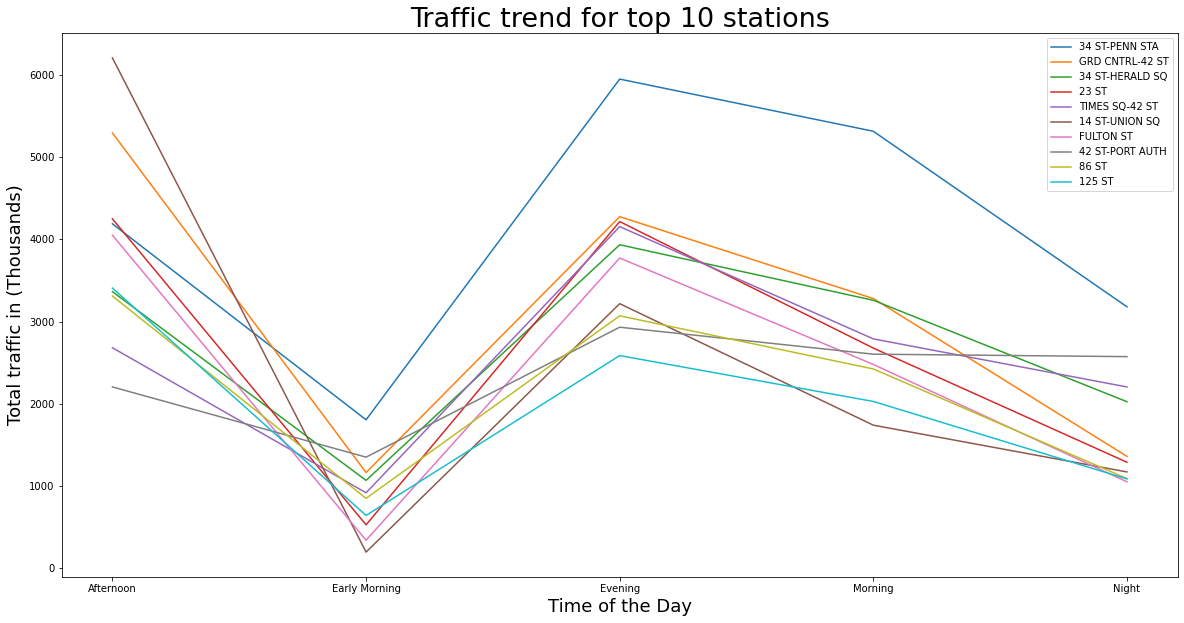

In [80]:
timeaxis_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]

for stations in Top10:
    station = Top10_station_slot[Top10_station_slot['STATION'] == stations]
#    print(station)
#    station.set_index('TIME_BINS').loc[timeaxis_list]
#    ax = df.set_index(field).loc[day_order].plot(kind="bar", legend=False)
#    station = station.set_index('TIME_BINS').loc[timeaxis_list]
    plt.plot(station['TIME_BINS'],station['TOTAL_TRAFFIC']/1000,label = stations)
#    plt.xticks(timeaxis_list)
    
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
#df.set_index(field).loc[day_order]
plt.xlabel("Time of the Day", fontsize=18)
plt.ylabel("Total traffic in (Thousands)",fontsize=18)
plt.title("Traffic trend for top 10 stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.legend()
plt.savefig('Traffic_trend.png',dpi = 300)
plt.show()
#plt.savefig('Traffic_trend.png',dpi = 300)
